In [47]:
import aquire_data
import h3
import pandas as pd
import numpy as np
import overpass

# Load data
# import data from VBOHCAR.xlsx to a pandas dataframe
import io
import pandas as pd
import requests
from os import listdir

# check for the vbohcar.xlsx file in the current directory
if 'VBOHCAR.xlsx' in listdir():
        # read the third sheet of the excel file
    df = pd.read_excel('VBOHCAR.xlsx', sheet_name=3)
else:
    # clone the excel file from github
    url = 'https://github.com/INFORMSJoC/2020.1022/blob/master/results/VBOHCAR.xlsx?raw=true'
    file = requests.get(url)
    file_bytes = io.BytesIO(file.content)
    # read the third sheet of the excel file
    df = pd.read_excel(file_bytes, sheet_name=3)
df.head()

,ID_OHCA,ReceivedTime,MinimumResponseTime,Latitude,Longitude,Incident_Location,X_OHCA,Y_OHCA,Z_OHCA
0,1,2017-01-01 00:49:54,5.666667,36.862471,-76.024169,1000 LINDSLEY DR_x000D_,1232.449963,-4951.984772,3826.080166
1,2,2017-01-01 06:35:29,20.750000,36.766897,-76.042337,2600 SPRINGHAVEN DR_x000D_,1232.417401,-4958.562301,3817.562796
2,3,2017-01-01 06:56:25,9.650000,36.766897,-76.042337,2600 SPRINGHAVEN DR_x000D_,1232.417401,-4958.562301,3817.562796
3,4,2017-01-01 17:05:56,11.083333,36.905880,-76.118769,4200 SHORE DR_x000D_,1223.576354,-4951.197334,3829.945177
4,5,2017-01-01 19:53:20,0.000000,36.620850,-76.090090,5200 BLACKWATER RD_x000D_,1230.619605,-4969.017372,3804.526862


In [48]:
hexid_ohca_cnt = {}
for i, row in df.iterrows():
    # get the hex_id for each row
    hex_id = h3.latlng_to_cell(np.float64(row['Latitude']), np.float64(row['Longitude']), 9)
    # if the hex_id is not in the dictionary, add it
    if hex_id not in hexid_ohca_cnt:
        hexid_ohca_cnt[hex_id] = 0
    # increment the count of OHCA in the hex_id
    hexid_ohca_cnt[hex_id] += 1

# create a dataframe from the dictionary with the hex_id as the index
ohca_df = pd.DataFrame.from_dict(hexid_ohca_cnt, orient='index', columns=['OHCA'])
print(sum(ohca_df['OHCA']))
ohca_df.head()

2706


,OHCA
892af636e43ffff,3
892af0c96abffff,2
892af63720bffff,4
892af051523ffff,2
892af6266bbffff,2


In [49]:
# load montgomery data
montgomery_df = pd.read_csv('montgomery/mtgmry_unfiltered.csv')
montgomery_df = montgomery_df[montgomery_df['title'].str.contains('CARDIAC ARREST')]
montgomery_df.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
32359,40.066426,-75.116878,BEECH TREE DR & BROOKVIEW PL; CHELTENHAM; Sta...,19027.0,EMS: CARDIAC ARREST,2016-02-29 19:04:30,CHELTENHAM,BEECH TREE DR & BROOKVIEW PL,1
32392,40.117738,-75.302071,SANDY HILL RD & HALLOWELL RD; PLYMOUTH; Stati...,19462.0,EMS: CARDIAC ARREST,2016-02-29 21:38:57,PLYMOUTH,SANDY HILL RD & HALLOWELL RD,1
32402,40.114876,-75.340390,GREEN ST & E AIRY ST; NORRISTOWN; Station 308...,19401.0,EMS: CARDIAC ARREST,2016-02-29 23:16:24,NORRISTOWN,GREEN ST & E AIRY ST,1
32530,40.252714,-75.652173,4TH ST & JOHNSON ST; POTTSTOWN; Station 329; ...,19464.0,EMS: CARDIAC ARREST,2016-03-01 10:58:55,POTTSTOWN,4TH ST & JOHNSON ST,1
33303,40.170217,-75.451468,YERKES RD & FAIRHILL DR; LOWER PROVIDENCE; St...,19426.0,EMS: CARDIAC ARREST,2016-03-03 08:59:36,LOWER PROVIDENCE,YERKES RD & FAIRHILL DR,1


In [50]:
# create a dictionary of hex_id and cardiac arrest counts
hexid_ca_cnt = {}
for i, row in montgomery_df.iterrows():
    # get the hex_id for each row
    hex_id = h3.latlng_to_cell(np.float64(row['lat']), np.float64(row['lng']), 9)
    # if the hex_id is not in the dictionary, add it
    if hex_id not in hexid_ca_cnt:
        hexid_ca_cnt[hex_id] = 0
    # increment the count of OHCA in the hex_id
    hexid_ca_cnt[hex_id] += 1

# create a dataframe from the dictionary with the hex_id as the index
ca_df = pd.DataFrame.from_dict(hexid_ca_cnt, orient='index', columns=['CA'])
print(sum(ca_df['CA']))
# add ca_df to ohca_df
ohca_df = ohca_df.join(ca_df)
ca_df.head()

6807


,CA
892a134a197ffff,2
892aac94e37ffff,5
892aac95d2fffff,20
892aac98367ffff,13
892aac82177ffff,1


In [51]:
# load virginia beach data
# check if virginia_beach.csv is in the current directory
if 'virginia_beach_osm.csv' in listdir():
    # read the csv file
    vb_df = pd.read_csv('virginia_beach_osm.csv')
    # set unnamed column name to hex_id
    vb_df.rename(columns={'Unnamed: 0': 'hex_id'}, inplace=True)
    # pivot the dataframe to have the hex_id as the index
    vb_df.set_index('hex_id', inplace=True)
else:
    vb_df = aquire_data.get_all_data('Virginia Beach', 9, date='2018-06-01T00:00:00Z')
if 'montgomery_osm.csv' in listdir():
    # read the csv file
    mnt_df = pd.read_csv('montgomery_osm.csv')
    # set unnamed column name to hex_id
    mnt_df.rename(columns={'Unnamed: 0': 'hex_id'}, inplace=True)
    # pivot the dataframe to have the hex_id as the index
    mnt_df.set_index('hex_id', inplace=True)
    # only keep columns columns that are in vb_df
    marin_cols = [col for col in mnt_df.columns if col in vb_df.columns]
    mnt_df = mnt_df[marin_cols]
    for col in vb_df.columns:
        if col not in mnt_df.columns:
            # drop it
            vb_df.drop(columns=col, inplace=True)
    for col in mnt_df.columns:
        if col not in vb_df.columns:
            # drop it
            mnt_df.drop(columns=col, inplace=True)

# add mnt_df to vb_df
vb_df = vb_df.join(mnt_df)
vb_df.head()

ValueError: columns overlap but no suffix specified: Index(['animal_boarding', 'atm', 'bank_x', 'bar_x', 'bench', 'bicycle_parking',
       'bicycle_repair_station', 'cafe_x', 'car_wash_x', 'charging_station',
       ...
       'shelter_y_neighbour_count', 'static_caravan_neighbour_count',
       'storage_tank_neighbour_count', 'studio_neighbour_count',
       'terrace_neighbour_count', 'toilets_y_neighbour_count',
       'townhall_neighbour_count', 'veterinary_y_neighbour_count',
       'warehouse_neighbour_count', 'yes_neighbour_count'],
      dtype='object', length=192)

In [ ]:
# add ca_df to ohca_df
ohca_df = ohca_df.join(ca_df)
# add OHCA count to virginia beach dataframe
vb_df = vb_df.join(ohca_df)
# vb_df = vb_df.join(ohca_df2)
# fill NaN values with 0
vb_df.fillna(0, inplace=True)
print(f"Ammount of rows: {len(vb_df)}")
print(f"Amount of OHCA: {sum(vb_df['OHCA'])}")
vb_df.head()

ValueError: columns overlap but no suffix specified: Index(['CA'], dtype='object')

In [ ]:
# load warsaw data
# check if warsaw.csv is in the current directory
if 'lublin_osm.csv' in listdir():
    # read the csv file
    warsaw_df = pd.read_csv('lublin_osm.csv')
    # set unnamed column name to hex_id
    warsaw_df.rename(columns={'Unnamed: 0': 'hex_id'}, inplace=True)
    # pivot the dataframe to have the hex_id as the index
    warsaw_df.set_index('hex_id', inplace=True)
else:
    warsaw_df = aquire_data.get_all_data('Lublin', 9)
warsaw_df.head()

,animal_breeding,atm,bank_x,bar_x,bbq,bench,bicycle_parking_x,bicycle_rental,bicycle_repair_station,boat_rental_x,...,townhall_neighbour_count,train_station_neighbour_count,transportation_neighbour_count,university_neighbour_count,vehicle_inspection_y_neighbour_count,veterinary_y_neighbour_count,warehouse_neighbour_count,waste_disposal_y_neighbour_count,waste_transfer_station_neighbour_count,yes_neighbour_count
hex_id,,,,,,,,,,,,,,,,,,,,,
891e2d08003ffff,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
891e2d08007ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
891e2d0800bffff,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
891e2d0800fffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
891e2d0801bffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


XGBRegressor Score: 0.018789149911336955


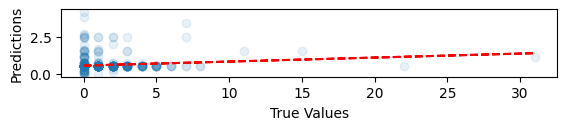

In [ ]:
# check model performance
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# pure xgboost
model = XGBRegressor(max_depth=9, n_estimators=1000, learning_rate=0.1, n_jobs=-1)
X_train, X_test, y_train, y_test = train_test_split(vb_df.drop(columns=['OHCA']), vb_df['OHCA'], test_size=0.2, random_state=42)
model.fit(X_train, y_train)
results = model.predict(X_test)
results = np.maximum(results, 0)
print(f"{model.__class__.__name__} Score: {model.score(X_test, y_test)}")


import matplotlib.pyplot as plt
# set equal axis
plt.gca().set_aspect('equal', adjustable='box')
# plot the results with opacity 0.1
plt.scatter(y_test, results, alpha=0.1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
# draw a best fit line
z = np.polyfit(y_test, results, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test),"r--")
plt.show()
plt.show()

In [ ]:
# check model performance
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

# pure xgboost
model = XGBRegressor(max_depth=9, n_estimators=1000, learning_rate=0.1, n_jobs=-1)
X = vb_df.drop(columns=['OHCA'])
y = vb_df['OHCA']
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# delete columns from warsaw_df that are not in vb_df, do the same for vb_df
war_cols = warsaw_df.columns
vb_cols = vb_df.columns
for col in war_cols:
    if col not in vb_cols:
        warsaw_df.drop(columns=[col], inplace=True)
for col in vb_cols:
    if col not in war_cols and col != 'OHCA':
        vb_df.drop(columns=[col], inplace=True)

# fit model on vb_df and predict OHCA count for warsaw_df
X = vb_df.drop(columns=['OHCA'])
y = vb_df['OHCA']

model.fit(X, y)
# predict the OHCA count for warsaw
warsaw_df['OHCA'] = model.predict(warsaw_df)
# set negative values to 0
warsaw_df['OHCA'] = np.maximum(warsaw_df['OHCA'], 0)
warsaw_df.head()

ValueError: feature_names mismatch: ['atm', 'bank_x', 'bar_x', 'bench', 'bicycle_repair_station', 'cafe_x', 'car_wash_x', 'charging_station', 'clinic_x', 'college_x', 'community_centre_x', 'courthouse', 'dentist_x', 'doctors_x', 'fast_food_x', 'fire_station_x', 'fountain', 'fuel_x', 'hospital_x', 'ice_cream_x', 'library_x', 'parking_x', 'parking_entrance', 'place_of_worship_x', 'police_x', 'post_box', 'post_office_x', 'restaurant_x', 'school_x', 'shelter_x', 'toilets_x', 'vending_machine', 'veterinary_x', 'apartments', 'bank_y', 'bar_y', 'barn', 'cabin', 'cafe_y', 'car_wash_y', 'chapel', 'church', 'clinic_y', 'college_y', 'commercial', 'community_centre_y', 'construction', 'dentist_y', 'detached', 'doctors_y', 'dormitory', 'fast_food_y', 'fire_station_y', 'fuel_y', 'garage', 'hospital_y', 'hotel', 'house', 'ice_cream_y', 'industrial', 'library_y', 'office', 'parking_y', 'place_of_worship_y', 'police_y', 'post_office_y', 'residential', 'restaurant_y', 'retail', 'roof', 'school_y', 'service', 'shed', 'shelter_y', 'storage_tank', 'terrace', 'toilets_y', 'townhall', 'veterinary_y', 'warehouse', 'yes', 'atm_neighbour_count', 'bank_x_neighbour_count', 'bar_x_neighbour_count', 'bench_neighbour_count', 'bicycle_repair_station_neighbour_count', 'cafe_x_neighbour_count', 'car_wash_x_neighbour_count', 'charging_station_neighbour_count', 'clinic_x_neighbour_count', 'college_x_neighbour_count', 'community_centre_x_neighbour_count', 'courthouse_neighbour_count', 'dentist_x_neighbour_count', 'doctors_x_neighbour_count', 'fast_food_x_neighbour_count', 'fire_station_x_neighbour_count', 'fountain_neighbour_count', 'fuel_x_neighbour_count', 'hospital_x_neighbour_count', 'ice_cream_x_neighbour_count', 'library_x_neighbour_count', 'parking_x_neighbour_count', 'parking_entrance_neighbour_count', 'place_of_worship_x_neighbour_count', 'police_x_neighbour_count', 'post_box_neighbour_count', 'post_office_x_neighbour_count', 'restaurant_x_neighbour_count', 'school_x_neighbour_count', 'shelter_x_neighbour_count', 'toilets_x_neighbour_count', 'vending_machine_neighbour_count', 'veterinary_x_neighbour_count', 'apartments_neighbour_count', 'bank_y_neighbour_count', 'bar_y_neighbour_count', 'barn_neighbour_count', 'cabin_neighbour_count', 'cafe_y_neighbour_count', 'car_wash_y_neighbour_count', 'chapel_neighbour_count', 'church_neighbour_count', 'clinic_y_neighbour_count', 'college_y_neighbour_count', 'commercial_neighbour_count', 'community_centre_y_neighbour_count', 'construction_neighbour_count', 'dentist_y_neighbour_count', 'detached_neighbour_count', 'doctors_y_neighbour_count', 'dormitory_neighbour_count', 'fast_food_y_neighbour_count', 'fire_station_y_neighbour_count', 'fuel_y_neighbour_count', 'garage_neighbour_count', 'hospital_y_neighbour_count', 'hotel_neighbour_count', 'house_neighbour_count', 'ice_cream_y_neighbour_count', 'industrial_neighbour_count', 'library_y_neighbour_count', 'office_neighbour_count', 'parking_y_neighbour_count', 'place_of_worship_y_neighbour_count', 'police_y_neighbour_count', 'post_office_y_neighbour_count', 'residential_neighbour_count', 'restaurant_y_neighbour_count', 'retail_neighbour_count', 'roof_neighbour_count', 'school_y_neighbour_count', 'service_neighbour_count', 'shed_neighbour_count', 'shelter_y_neighbour_count', 'storage_tank_neighbour_count', 'terrace_neighbour_count', 'toilets_y_neighbour_count', 'townhall_neighbour_count', 'veterinary_y_neighbour_count', 'warehouse_neighbour_count', 'yes_neighbour_count'] ['atm', 'bank_x', 'bar_x', 'bench', 'bicycle_repair_station', 'cafe_x', 'car_wash_x', 'charging_station', 'clinic_x', 'college_x', 'community_centre_x', 'dentist_x', 'doctors_x', 'fast_food_x', 'fire_station_x', 'fountain', 'fuel_x', 'hospital_x', 'ice_cream_x', 'library_x', 'parking_x', 'parking_entrance', 'place_of_worship_x', 'police_x', 'post_box', 'post_office_x', 'restaurant_x', 'school_x', 'shelter_x', 'toilets_x', 'vending_machine', 'veterinary_x', 'apartments', 'bank_y', 'bar_y', 'barn', 'cabin', 'cafe_y', 'car_wash_y', 'chapel', 'church', 'clinic_y', 'college_y', 'commercial', 'community_centre_y', 'construction', 'courthouse', 'dentist_y', 'detached', 'doctors_y', 'dormitory', 'fast_food_y', 'fire_station_y', 'fuel_y', 'garage', 'hospital_y', 'hotel', 'house', 'ice_cream_y', 'industrial', 'library_y', 'office', 'parking_y', 'place_of_worship_y', 'police_y', 'post_office_y', 'residential', 'restaurant_y', 'retail', 'roof', 'school_y', 'service', 'shed', 'shelter_y', 'storage_tank', 'terrace', 'toilets_y', 'townhall', 'veterinary_y', 'warehouse', 'yes', 'atm_neighbour_count', 'bank_x_neighbour_count', 'bar_x_neighbour_count', 'bench_neighbour_count', 'bicycle_repair_station_neighbour_count', 'cafe_x_neighbour_count', 'car_wash_x_neighbour_count', 'charging_station_neighbour_count', 'clinic_x_neighbour_count', 'college_x_neighbour_count', 'community_centre_x_neighbour_count', 'dentist_x_neighbour_count', 'doctors_x_neighbour_count', 'fast_food_x_neighbour_count', 'fire_station_x_neighbour_count', 'fountain_neighbour_count', 'fuel_x_neighbour_count', 'hospital_x_neighbour_count', 'ice_cream_x_neighbour_count', 'library_x_neighbour_count', 'parking_x_neighbour_count', 'parking_entrance_neighbour_count', 'place_of_worship_x_neighbour_count', 'police_x_neighbour_count', 'post_box_neighbour_count', 'post_office_x_neighbour_count', 'restaurant_x_neighbour_count', 'school_x_neighbour_count', 'shelter_x_neighbour_count', 'toilets_x_neighbour_count', 'vending_machine_neighbour_count', 'veterinary_x_neighbour_count', 'apartments_neighbour_count', 'bank_y_neighbour_count', 'bar_y_neighbour_count', 'barn_neighbour_count', 'cabin_neighbour_count', 'cafe_y_neighbour_count', 'car_wash_y_neighbour_count', 'chapel_neighbour_count', 'church_neighbour_count', 'clinic_y_neighbour_count', 'college_y_neighbour_count', 'commercial_neighbour_count', 'community_centre_y_neighbour_count', 'construction_neighbour_count', 'courthouse_neighbour_count', 'dentist_y_neighbour_count', 'detached_neighbour_count', 'doctors_y_neighbour_count', 'dormitory_neighbour_count', 'fast_food_y_neighbour_count', 'fire_station_y_neighbour_count', 'fuel_y_neighbour_count', 'garage_neighbour_count', 'hospital_y_neighbour_count', 'hotel_neighbour_count', 'house_neighbour_count', 'ice_cream_y_neighbour_count', 'industrial_neighbour_count', 'library_y_neighbour_count', 'office_neighbour_count', 'parking_y_neighbour_count', 'place_of_worship_y_neighbour_count', 'police_y_neighbour_count', 'post_office_y_neighbour_count', 'residential_neighbour_count', 'restaurant_y_neighbour_count', 'retail_neighbour_count', 'roof_neighbour_count', 'school_y_neighbour_count', 'service_neighbour_count', 'shed_neighbour_count', 'shelter_y_neighbour_count', 'storage_tank_neighbour_count', 'terrace_neighbour_count', 'toilets_y_neighbour_count', 'townhall_neighbour_count', 'veterinary_y_neighbour_count', 'warehouse_neighbour_count', 'yes_neighbour_count']

In [ ]:
# add a column if there is a defibrillator in the hexagon
# https://aed.openstreetmap.org.pl/aed_poland.geojson
import requests
aed_url = 'https://aed.openstreetmap.org.pl/aed_poland.geojson'
aed_file = requests.get(aed_url)
aed_json = aed_file.json()

# create a column with aed count
warsaw_df['aed_count'] = 0

# iterate through aeds find the hexagon and add 1 to the column
for aed in aed_json['features']:
    x, y = aed["geometry"]["coordinates"]
    hexagon = h3.latlng_to_cell(y, x, 9)
    if hexagon in warsaw_df.index:
        warsaw_df.loc[hexagon, 'aed_count'] += 1

In [ ]:
# get feature importances
feature_importances = model.feature_importances_
# sort indices by importance
indices = np.argsort(feature_importances)
# get feature names
feature_names = X.columns
# sort feature names by importance
feature_names = feature_names[indices]
# get feature importances sorted
feature_importances = feature_importances[indices]
# create a dataframe with feature names and importances
feature_importances_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
# display the dataframe
# write to csv
feature_importances_df.to_csv('feature_importances.csv')

NameError: name 'model' is not defined

In [ ]:
# create a map, color hexagons by the predicted number of ohca
import folium

m = folium.Map(location=[51.2465, 22.5684], zoom_start=11)

max_ohca = warsaw_df['OHCA'].max()

# get top 10 hexagons with the most predicted ohca that have no defibrillators or hospitals
top_10_hexagons = warsaw_df[warsaw_df['aed_count'] == 0].sort_values(by='OHCA', ascending=False).head(10)

# add hexagons with opacity based on the number of ohca
for i, row in warsaw_df.iterrows():
    if row['aed_count'] == 0:
        boundary = h3.cell_to_boundary(i)
        folium.Polygon(locations=boundary, fill_color='red', fill_opacity=row['OHCA']/max_ohca).add_to(m)
    else:
        boundary = h3.cell_to_boundary(i)
        folium.Polygon(locations=boundary, fill_color='green', fill_opacity=row['OHCA']/max_ohca).add_to(m)
m.save('lublin.html')
m